# Wprowadzenie do sieci neuronowych i uczenia maszynowego

## Lab: Własne moduły w PyTorch, regularyzacja i autoenkodery

---

**Autorzy materiałów:** Marek Wydmuch, Iwo Błądek, Jakub Bednarek<br>

---

## Uwaga

* **Aby wykonać polecenia należy najpierw przejść do trybu 'playground'. File -> Open in Playground Mode**
* Nowe funkcje Colab pozwalają na autouzupełnianie oraz czytanie dokumentacji.


## Cel ćwiczeń:

- zapoznanie się z tworzeniem własnych modułów w PyTorch
- wykorzystanie podstawowych mechanizmów regularyzacji: Dropout i Batch normalization

In [29]:
import numpy as np
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu121
CUDA available: True


In [30]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## Własne moduły (warstwy sieci neuronowych) w PyTorch



Na poprzednich zajęciach używaliśmy gotowych modułów reprezentujących warstwy sieci neuronowych by stworzyć główny moduł naszego modułu.

W PyTorch nie ma żadnej hierarchii modułów (jak np. w TensorFlow czy Keras, gdzie API jest podzielone na modele i warstwy). Każdy moduł może używać innych modułów jako swoich komponentów.

Poniżej przykładowa implementacja modułu warstwy liniowej całkowicie od podstaw.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

class CustomLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomLayer, self).__init__()
        # Parametry (wagi) naszego modułu
        self.weights = nn.Parameter(torch.Tensor(input_dim, output_dim))
        # Inicjalizacja wag
        nn.init.xavier_normal_(self.weights)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return torch.mm(x, self.weights)

class CustomModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__()
        self.layers = nn.Sequential(
            CustomLayer(784, 512),
            nn.ReLU(),
            CustomLayer(512, 512),
            nn.ReLU(),
            CustomLayer(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)

In [32]:
# Setup naszego modelu
model = CustomModel(num_classes=10).cuda()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

def accuracy(pred, target):
    return (pred.argmax(1) == target).type(torch.float).sum().item()

# Pętla treningowa i testowa
def train_and_test(
        train_loader,
        test_loader,
        model,
        optimizer,
        criterion,
        metric=None,
        epochs=10,
        verbose=False
    ):
    epochs_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_metric = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.cuda()
            target = target.cuda()
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            if verbose and batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
            train_loss += loss.item() * data.size(0)
            train_metric += metric(pred, target)
        if verbose:
            train_loss /= len(train_loader.dataset)
            train_metric /= len(train_loader.dataset)
            print(f"Train loss: {train_loss:.4f}")
            print(f"Train {metric.__name__}: {train_metric:.4f}")

        model.eval()
        test_metric = 0
        test_loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.cuda()
            target = target.cuda()
            pred = model(data)
            loss = criterion(pred, target)
            test_loss += loss.item() * data.size(0)
            test_metric += metric(pred, target)
        if verbose:
            test_loss /= len(test_loader.dataset)
            test_metric /= len(test_loader.dataset)
            print(f"Test loss: {test_loss:.4f}")
            print(f"Test accuracy: {test_metric:.4f}")
            print("-------------------------------")

        epochs_history.append({
          "epoch": epoch,
          "train_loss": train_loss,
          f"train_{metric.__name__}": train_metric,
          "test_loss": test_loss,
          f"test_{metric.__name__}": test_metric
        })
    return epochs_history

_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)

Epoch: 0, Batch: 0, Loss: 2.3072
Epoch: 0, Batch: 100, Loss: 1.6753
Epoch: 0, Batch: 200, Loss: 1.6981
Epoch: 0, Batch: 300, Loss: 1.5887
Epoch: 0, Batch: 400, Loss: 1.5056
Train loss: 1.6357
Train accuracy: 0.8310
Test loss: 1.5079
Test accuracy: 0.9556
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.5216
Epoch: 1, Batch: 100, Loss: 1.4871
Epoch: 1, Batch: 200, Loss: 1.4901
Epoch: 1, Batch: 300, Loss: 1.5099
Epoch: 1, Batch: 400, Loss: 1.5132
Train loss: 1.5044
Train accuracy: 0.9579
Test loss: 1.4949
Test accuracy: 0.9681
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.4821
Epoch: 2, Batch: 100, Loss: 1.4816
Epoch: 2, Batch: 200, Loss: 1.5020
Epoch: 2, Batch: 300, Loss: 1.4938
Epoch: 2, Batch: 400, Loss: 1.4722
Train loss: 1.4930
Train accuracy: 0.9693
Test loss: 1.5008
Test accuracy: 0.9610
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.5117
Epoch: 3, Batch: 100, Loss: 1.4924
Epoch: 3, Batch: 200, Loss: 1.5010
Epoch: 3, Batch: 300, Loss: 1.4903
E

### Zadanie 1

Stwórz prosty model
- warstwy konwolucyjnej (Conv2D): 32 filtry 3x3,
- konwolucyjnej: 64 filtry 3x3,
- warstwy MaxPooling (MaxPooling2D): 2x2
- warstwy ukrytej gęstej (Dense): 128 neuronów,
- warstwy wyjściowej.

Ważne:
- w każdej warstwie poza warstwą wyjściową funkcją aktywacji powinno być relu,
- funkcja aktywacji dla warstwy wyjściowej to softmax,
- między częścią konwolucyjną a gęstą trzeba spłaszczyć tensor przy pomocy warstwy `nn.Flatten`.

In [10]:
class SimpleModel(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleModel, self).__init__()
        self.layers = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Flatten(),
          nn.Linear(64 * (28 // 2) * (28 // 2), 128),
          nn.ReLU(),
        # Warstwa wyjściowa
          nn.Linear(128, num_classes),
          nn.Softmax(dim=1)
        )
        self._initialize_weights()

    # Inicjalizacja parametrów, która znacząco poprawi początkowe uczenie
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

model = SimpleModel(num_classes=10).cuda()
optimizer = optim.Adam(model.parameters())
_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)

Epoch: 0, Batch: 0, Loss: 2.3020
Epoch: 0, Batch: 100, Loss: 1.5280
Epoch: 0, Batch: 200, Loss: 1.4982
Epoch: 0, Batch: 300, Loss: 1.4860
Epoch: 0, Batch: 400, Loss: 1.4889
Train loss: 1.5339
Train accuracy: 0.9336
Test loss: 1.4872
Test accuracy: 0.9749
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.4786
Epoch: 1, Batch: 100, Loss: 1.4971
Epoch: 1, Batch: 200, Loss: 1.4678
Epoch: 1, Batch: 300, Loss: 1.4864
Epoch: 1, Batch: 400, Loss: 1.4807
Train loss: 1.4827
Train accuracy: 0.9795
Test loss: 1.4791
Test accuracy: 0.9832
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.4691
Epoch: 2, Batch: 100, Loss: 1.4874
Epoch: 2, Batch: 200, Loss: 1.4746
Epoch: 2, Batch: 300, Loss: 1.4867
Epoch: 2, Batch: 400, Loss: 1.4906
Train loss: 1.4773
Train accuracy: 0.9846
Test loss: 1.4794
Test accuracy: 0.9824
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.4745
Epoch: 3, Batch: 100, Loss: 1.4970
Epoch: 3, Batch: 200, Loss: 1.4706
Epoch: 3, Batch: 300, Loss: 1.4675
E

## Zadanie 2

Na podstawie powyższego przykładu stwórz moduł bloku ResNet.
Zadbaj o to by rozmiary tensorów po warstwach konwolucyjnych się nie zmieniały.

![resnet](https://miro.medium.com/max/1000/1*6HDuqhUzP92iXhHoS0Wl3w.png)

Zmodyfikuj model z zadania 1, zamieniając warstwy konwolucyjne na dwa modele bloku ResNet.



In [16]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        #ReLu Added in between 2 convolutions
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += identity  # Element-wise addition
        out = self.relu(out)
        return out

class SimpleModel(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleModel, self).__init__()
        self.resnet_blocks = nn.Sequential(
            ResNetBlock(in_channels=1, out_channels=64),
            ResNetBlock(in_channels=64, out_channels=64),
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.resnet_blocks(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

model = SimpleModel(num_classes=10).cuda()
optimizer = optim.Adam(model.parameters())
_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)


Epoch: 0, Batch: 0, Loss: 2.3085
Epoch: 0, Batch: 100, Loss: 1.7363
Epoch: 0, Batch: 200, Loss: 1.6021
Epoch: 0, Batch: 300, Loss: 1.6122
Epoch: 0, Batch: 400, Loss: 1.6352
Train loss: 1.6492
Train accuracy: 0.8110
Test loss: 1.5828
Test accuracy: 0.8779
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.5708
Epoch: 1, Batch: 100, Loss: 1.5998
Epoch: 1, Batch: 200, Loss: 1.6193
Epoch: 1, Batch: 300, Loss: 1.5063
Epoch: 1, Batch: 400, Loss: 1.4857
Train loss: 1.5468
Train accuracy: 0.9141
Test loss: 1.4860
Test accuracy: 0.9753
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.4791
Epoch: 2, Batch: 100, Loss: 1.4612
Epoch: 2, Batch: 200, Loss: 1.4928
Epoch: 2, Batch: 300, Loss: 1.5065
Epoch: 2, Batch: 400, Loss: 1.4780
Train loss: 1.4897
Train accuracy: 0.9714
Test loss: 1.4899
Test accuracy: 0.9709
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.4829
Epoch: 3, Batch: 100, Loss: 1.4690
Epoch: 3, Batch: 200, Loss: 1.4951
Epoch: 3, Batch: 300, Loss: 1.4612
E

## Regularyzacja

### Zadanie 3

Rozszerz model stworzony w zadaniu 1 o dwie warstwy Dropout (nn.Dropout):
- jedna po warstwie MaxPooling (wartość współczynnika odrzucenia 0.25)
- druga po gęstej warstwie ukrytej (Dense), wartość współczynnika odrzucenia 0.5.
- dodaj opcję włączenia i wyłączenia dropoutu jako argument konstruktora modułu modelu.



In [17]:
class SimpleModel(nn.Module):
    def __init__(self, num_classes=10, use_dropout=True):
        super(SimpleModel, self).__init__()
        self.use_dropout = use_dropout

        layers = [
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        ]

        if self.use_dropout:
            layers.append(nn.Dropout(p=0.25))  # Dropout after MaxPooling

        layers += [
            nn.Flatten(),
            nn.Linear(64 * (28 // 2) * (28 // 2), 128),
            nn.ReLU(),
        ]

        if self.use_dropout:
            layers.append(nn.Dropout(p=0.5))  # Dropout po warstwie gęstej

        layers += [
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1),
        ]

        self.layers = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)


model = SimpleModel(num_classes=10, use_dropout=True).cuda()
optimizer = torch.optim.Adam(model.parameters())
_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)


Epoch: 0, Batch: 0, Loss: 2.3030
Epoch: 0, Batch: 100, Loss: 1.6582
Epoch: 0, Batch: 200, Loss: 1.5702
Epoch: 0, Batch: 300, Loss: 1.5113
Epoch: 0, Batch: 400, Loss: 1.5184
Train loss: 1.5886
Train accuracy: 0.8774
Test loss: 1.4916
Test accuracy: 0.9694
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.4991
Epoch: 1, Batch: 100, Loss: 1.5040
Epoch: 1, Batch: 200, Loss: 1.4785
Epoch: 1, Batch: 300, Loss: 1.5073
Epoch: 1, Batch: 400, Loss: 1.4767
Train loss: 1.5029
Train accuracy: 0.9602
Test loss: 1.4835
Test accuracy: 0.9779
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.4949
Epoch: 2, Batch: 100, Loss: 1.4640
Epoch: 2, Batch: 200, Loss: 1.5170
Epoch: 2, Batch: 300, Loss: 1.4984
Epoch: 2, Batch: 400, Loss: 1.4820
Train loss: 1.4934
Train accuracy: 0.9688
Test loss: 1.4790
Test accuracy: 0.9826
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.4889
Epoch: 3, Batch: 100, Loss: 1.4690
Epoch: 3, Batch: 200, Loss: 1.4629
Epoch: 3, Batch: 300, Loss: 1.4943
E

### Zadanie 4
Rozszerz model stworzony w poprzednich zadaniach o dwie warstwy Batch normalization (nn.BatchNorm2d) po warstwach konwolucyjnych. Dodaj opcję włączenia i wyłączenia dropoutu jako argument konstruktora modułu modelu.



In [19]:
class SimpleModel(nn.Module):
    def __init__(self, num_classes=10, use_dropout=True):
        super(SimpleModel, self).__init__()
        self.use_dropout = use_dropout

        layers = [
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
        ]

        if self.use_dropout:
            layers.append(nn.Dropout(p=0.25))  # Dropout after MaxPooling

        layers += [
            nn.Flatten(),
            nn.Linear(64 * (28 // 2) * (28 // 2), 128),
            nn.ReLU(),
        ]

        if self.use_dropout:
            layers.append(nn.Dropout(p=0.5))  # Dropout po warstwie gęstej

        layers += [
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1),
        ]

        self.layers = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)


model = SimpleModel(num_classes=10, use_dropout=False).cuda()
optimizer = torch.optim.Adam(model.parameters())
_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)

Epoch: 0, Batch: 0, Loss: 2.2913
Epoch: 0, Batch: 100, Loss: 1.9992
Epoch: 0, Batch: 200, Loss: 2.0603
Epoch: 0, Batch: 300, Loss: 1.9686
Epoch: 0, Batch: 400, Loss: 1.9270
Train loss: 1.9616
Train accuracy: 0.4979
Test loss: 1.8626
Test accuracy: 0.5976
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.8603
Epoch: 1, Batch: 100, Loss: 1.8239
Epoch: 1, Batch: 200, Loss: 1.8446
Epoch: 1, Batch: 300, Loss: 1.8563
Epoch: 1, Batch: 400, Loss: 1.8611
Train loss: 1.8394
Train accuracy: 0.6208
Test loss: 1.7734
Test accuracy: 0.6870
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.8044
Epoch: 2, Batch: 100, Loss: 1.7803
Epoch: 2, Batch: 200, Loss: 1.8589
Epoch: 2, Batch: 300, Loss: 1.7724
Epoch: 2, Batch: 400, Loss: 1.7667
Train loss: 1.7657
Train accuracy: 0.6946
Test loss: 1.6790
Test accuracy: 0.7818
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.6150
Epoch: 3, Batch: 100, Loss: 1.6239
Epoch: 3, Batch: 200, Loss: 1.5685
Epoch: 3, Batch: 300, Loss: 1.5931
E

### Zadanie 5
Porównaj model bez oraz z różnych kombinacjami technik regularyzacji (z dropoutem ale bez batch norm., bez dropout ale z batch norm., z dropoutem i z batch norm.).
Stwórz cztery wykresy:
- błąd funkcji celu dla zbioru treningowego,
- błąd funkcji celu dla zbioru walidacyjnego,
- trafność klasyfikacji dla zbioru treningowego,
- trafność klasyfikacji dla zbioru walidacyjnego.

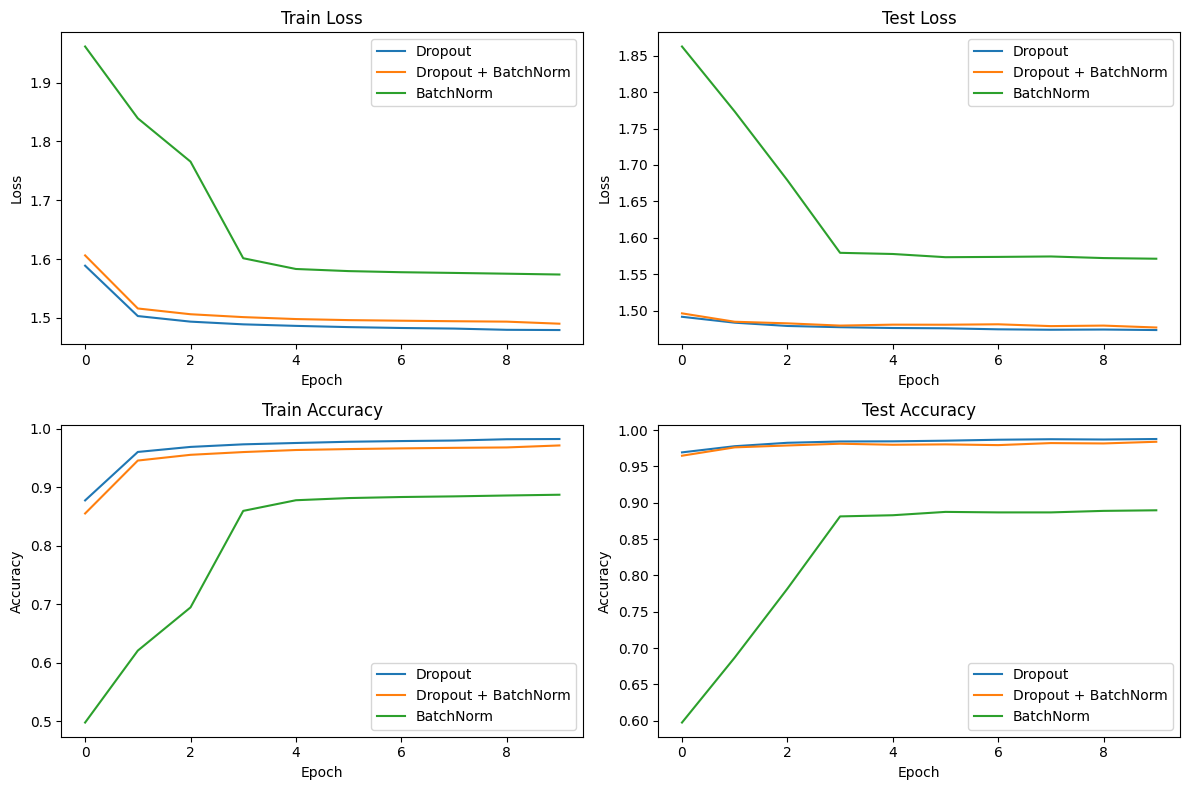

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for different regularization combinations
data = {
    "epoch": list(range(10)),
    "dropout_train_loss": [1.5886, 1.5029, 1.4934, 1.4888, 1.4862, 1.4841, 1.4826, 1.4816, 1.4795, 1.4791],
    "dropout_test_loss": [1.4916, 1.4835, 1.4790, 1.4773, 1.4762, 1.4758, 1.4744, 1.4738, 1.4741, 1.4734],
    "dropout_train_accuracy": [0.8774, 0.9602, 0.9688, 0.9732, 0.9755, 0.9776, 0.9788, 0.9797, 0.9819, 0.9823],
    "dropout_test_accuracy": [0.9694, 0.9779, 0.9826, 0.9844, 0.9846, 0.9855, 0.9868, 0.9875, 0.9871, 0.9878],
    "dropout_bn_train_loss": [1.6061, 1.5158, 1.5060, 1.5011, 1.4978, 1.4960, 1.4950, 1.4941, 1.4934, 1.4899],
    "dropout_bn_test_loss": [1.4963, 1.4848, 1.4826, 1.4795, 1.4808, 1.4807, 1.4813, 1.4788, 1.4795, 1.4769],
    "dropout_bn_train_accuracy": [0.8551, 0.9455, 0.9553, 0.9600, 0.9635, 0.9651, 0.9663, 0.9672, 0.9679, 0.9713],
    "dropout_bn_test_accuracy": [0.9648, 0.9763, 0.9789, 0.9813, 0.9799, 0.9804, 0.9794, 0.9822, 0.9817, 0.9840],
    "bn_train_loss": [1.9616, 1.8394, 1.7657, 1.6013, 1.5830, 1.5794, 1.5775, 1.5763, 1.5750, 1.5736],
    "bn_test_loss": [1.8626, 1.7734, 1.6790, 1.5794, 1.5778, 1.5734, 1.5738, 1.5744, 1.5722, 1.5713],
    "bn_train_accuracy": [0.4979, 0.6208, 0.6946, 0.8595, 0.8777, 0.8814, 0.8832, 0.8843, 0.8858, 0.8871],
    "bn_test_accuracy": [0.5976, 0.6870, 0.7818, 0.8813, 0.8829, 0.8875, 0.8868, 0.8868, 0.8889, 0.8897],
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 8))

# Train Loss
plt.subplot(2, 2, 1)
plt.plot(df["epoch"], df["dropout_train_loss"], label="Dropout")
plt.plot(df["epoch"], df["dropout_bn_train_loss"], label="Dropout + BatchNorm")
plt.plot(df["epoch"], df["bn_train_loss"], label="BatchNorm")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Test Loss
plt.subplot(2, 2, 2)
plt.plot(df["epoch"], df["dropout_test_loss"], label="Dropout")
plt.plot(df["epoch"], df["dropout_bn_test_loss"], label="Dropout + BatchNorm")
plt.plot(df["epoch"], df["bn_test_loss"], label="BatchNorm")
plt.title("Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Train Accuracy
plt.subplot(2, 2, 3)
plt.plot(df["epoch"], df["dropout_train_accuracy"], label="Dropout")
plt.plot(df["epoch"], df["dropout_bn_train_accuracy"], label="Dropout + BatchNorm")
plt.plot(df["epoch"], df["bn_train_accuracy"], label="BatchNorm")
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Test Accuracy
plt.subplot(2, 2, 4)
plt.plot(df["epoch"], df["dropout_test_accuracy"], label="Dropout")
plt.plot(df["epoch"], df["dropout_bn_test_accuracy"], label="Dropout + BatchNorm")
plt.plot(df["epoch"], df["bn_test_accuracy"], label="BatchNorm")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


## Autoenkodery

Ideę autoenkodera prezentuje poniższy rysunek:
![label-autoencoder_schema](https://drive.google.com/uc?export=view&id=1Ai2ER1ppKfnHg5t_lCwO_fvvFNe59dgd)

Widzimy tutaj, że obrazek ze zbioru MNIST o rozmiarze 28 x 28 został skompresowany przez **enkoder** do tensora o rozmiarze 5 x 2. Tensor ten nosi nazwę **wektora zmiennych ukrytych** (ang. latent vector). Następnie **dekoder** przyjął ten wektor na wejście, i odtworzył oryginalny obrazek. Jest to przykład zadania **autoasocjacji**, gdzie celem uczenia sieci neuronowej jest możliwie wierne odtworzenie danych wejściowych. Zadanie to może się wydawać bez sensu w odosobnieniu (po co odtwarzać coś, co już mamy?), jednak to co nas najbardziej interesuje w autoenkoderze to wektor zmiennych ukrytych. Jako że skompresowaliśmy cały obrazek do 10 wartości, to by realistyczne odtworzenie z nich oryginalnego obrazka było możliwe, każda z tych wartości musi 1) zawierać o nim możliwie dużo informacji, 2) nieistotne detale oryginalnego obrazka muszą zostać pominięte. Wyciągnęliśmy więc z danych informacyjną "esencję", pozbyliśmy się redundatnych elementów opisu.

<br>

Najważniejszą cechą autoenkodera jest właśnie **uczenie się efektywnego kodowania danych**, co zazwyczaj wiąże się z redukcją wymiarowości (tzw. 'undercomplete autoencoders'), choć można też uczyć autoenkodery o kodowaniu zwiększającym wymiarowość (tzw. 'overcomplete autoencoders'). Skupimy się na autoenkoderach zmniejszających wymiarowość, bo ich uczenie jest znacznie prostsze. W przeciwieństwie do np. PCA kodowanie uzyskane przez taki autoenkoder może być nieliniowe, tak więc zmienne ukryte mają więcej elastyczności w reprezentacji danych. Selekcja atrybutów, której podstawy omawialiśmy wcześniej na przedmiocie, również redukuje wymiarowość, ale nie zmienia informacji w atrybutach. W ogólności techniki redukcji wymiarowości tworzą zupełnie nowe atrybuty ze starych (np. $Y_1 = 0.5X_1 - 0.25X_2^2 + \log_2 X_3$, gdzie $Y_1$ to nowy atrybut, a $X_i$ to oryginalne atrybuty). Wiele zastosowań autoenkoderów buduje właśnie na tej zdolności, a także na tym, że dzięki procesowi uczenia sieci tworzymy metodę redukcji wymiarowości zoptymalizowaną do konkretnego problemu.

<br>

Autoenkodery mają wiele potencjalnych zastosowań, przykładowo:
* Redukcja wymiarowości - uczymy autoenkoder w trybie autoasocjacji, i naszym celem jest zmniejszenie wymiarowości danych, czyli zastąpienie oryginalnego obiektu jego wektorem zmiennych ukrytych. Można użyć jako alternatywy dla selekcji atrybutów i dedykowanych metod redukcji wymiarowości (PCA, LDA, etc.).
* Grupowanie - uczymy autoenkoder w trybie autoasocjacji, wykorzystujemy wektory zmiennych ukrytych uzyskane dla danych uczących jako wejście do algorytmu grupowania (np. k-means).
* Wyszukiwanie informacji - uczymy autoenkoder w trybie autoasocjacji, wykorzystujemy wektor zmiennych ukrytych jako hasz obiektu. Jeżeli chcemy znaleźć w bazie danych obiekty podobne do zadanego obiektu $X$, to generujemy wektor zmiennych ukrytych (hasz) $X$ przy użyciu enkodera i szukamy obiektów w zbiorze o najbardziej zbliżonych haszach. Technika ta nazywana jest haszowaniem semantycznym.
* Wykrywanie anomalii - uczymy autoenkoder w trybie autoasocjacji wyłącznie na przypadkach "normalnych". Liczymy na to, że jak kiedykolwiek autoenkoder dostanie do przetworzenia przypadek odstający/anomalię, to nie da rady jej dobrze zrekonstruować i błąd będzie wysoki (właśnie przez to, że nie miał szansy się na nich nauczyć).
* Generowanie danych - uczymy autoenkoder w trybie autoasocjacji, a następnie jak chcemy uzyskać różne warianty danego obrazu/obiektu, to modyfikujemy jego wygenerowany przez enkoder wektor zmiennych ukrytych, i dajemy go do przetworzenia dekoderowi. Możemy też po prostu losowo próbkować przestrzeń wektorów ukrytych i obserwować wyniki po przetworzeniu przez dekoder. Przy odrobinie szczęścia jakaś zmienna ukryta może np. odpowiadać za wyraz twarzy człowieka, i zmieniając wartości tej zmiennej możemy zmieniać wyłącznie wyraz twarzy człowieka na zdjęciu. Do tego zadania zazwyczaj wykorzystywany jest zmodyfikowany wariant autoenkodera: autoenkoder wariacyjny.
* Odszumianie - uczymy autoenkoder w trybie heteroasocjacji: *zaszumiony obraz* -> *oryginalny obraz*. Liczymy na to, że enkoder i dekoder nauczą się poprawnie rozpoznawać szum jako element redundantny, nieniosący żadnej informacji.<br>
![label-autoencoder_denoising](https://drive.google.com/uc?export=view&id=1a1fP7CWjzKSwo0txUBUMwaxTrpt6LzyH)



### Zadanie 6

Zaimplementuj autoenkoder o następującej architekturze:
* Enkoder: Dense(100) -> Dense(50) -> Dense(10) (wektor zmiennych ukrytych).
* Dekoder: Dense (50) -> Dense(100) -> Dense(784) (wyjściowy zrekonstruowany obrazek)

Funkcję aktywacji ustaw jako 'relu'. Jako miara błędu użyte zostanie MSE.

In [35]:
import torch
import torch.nn as nn
import torch.nn.init as init

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 784),
            nn.Sigmoid(),
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                init.constant_(m.bias, 0)

    def forward(self, x):
        # Ensure input is flattened
        x = x.view(-1, 784)
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        return decoded

# Ensure model and data are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:  # Assuming train_loader provides image batches
        images = images.to(device)  # Move images to the same device as the model
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images.view(-1, 784))
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)  # Move images to the same device as the model
            outputs = model(images)
            loss = criterion(outputs, images.view(-1, 784))
            val_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(test_loader):.4f}")

Epoch 1/20, Train Loss: 0.0663, Validation Loss: 0.0510
Epoch 2/20, Train Loss: 0.0452, Validation Loss: 0.0404
Epoch 3/20, Train Loss: 0.0391, Validation Loss: 0.0377
Epoch 4/20, Train Loss: 0.0371, Validation Loss: 0.0363
Epoch 5/20, Train Loss: 0.0355, Validation Loss: 0.0340
Epoch 6/20, Train Loss: 0.0331, Validation Loss: 0.0320
Epoch 7/20, Train Loss: 0.0318, Validation Loss: 0.0311
Epoch 8/20, Train Loss: 0.0310, Validation Loss: 0.0305
Epoch 9/20, Train Loss: 0.0303, Validation Loss: 0.0300
Epoch 10/20, Train Loss: 0.0299, Validation Loss: 0.0297
Epoch 11/20, Train Loss: 0.0295, Validation Loss: 0.0293
Epoch 12/20, Train Loss: 0.0289, Validation Loss: 0.0281
Epoch 13/20, Train Loss: 0.0278, Validation Loss: 0.0275
Epoch 14/20, Train Loss: 0.0273, Validation Loss: 0.0270
Epoch 15/20, Train Loss: 0.0269, Validation Loss: 0.0268
Epoch 16/20, Train Loss: 0.0265, Validation Loss: 0.0264
Epoch 17/20, Train Loss: 0.0262, Validation Loss: 0.0261
Epoch 18/20, Train Loss: 0.0259, Validat

### Zadanie 7

Użyj zaimplementowanego wyżej autoenkodera by zaobserwować jak zmienia się odtwarzany obraz gdy zmienia się tylko jeden element wektora zmiennych ukrytych. Zadanie wykonywane jest w następujących krokach:
1. Użyj nauczonego enkodera z poprzedniego zadania na przypadku uczącym wybranej cyfry (dowolnej) by uzyskać wektor zmiennych ukrytych.
2. Wybierz konkretną zmienną ukrytą w tym wektorze, np. tę o indeksie 0.
3. W pętli podstawiaj różne wartości do tej zmiennej wektora z pewnym krokiem, i obserwuj obrazki generowane przez dekoder.

Original image


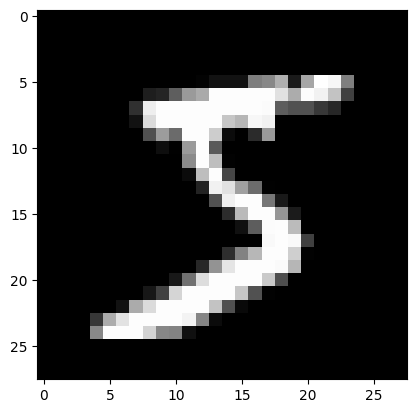

Reconstructed image


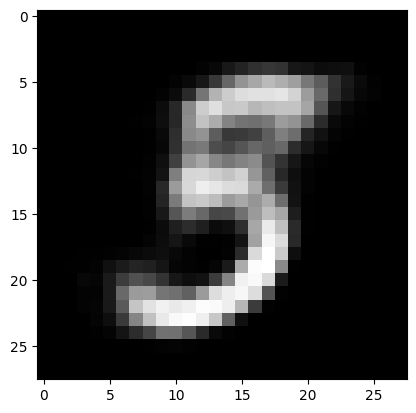

latent_vector: [[0.        0.        0.        3.4594567 0.        7.2495923 8.301601
  7.173057  2.2645016 3.3874552]]
e: 0.0


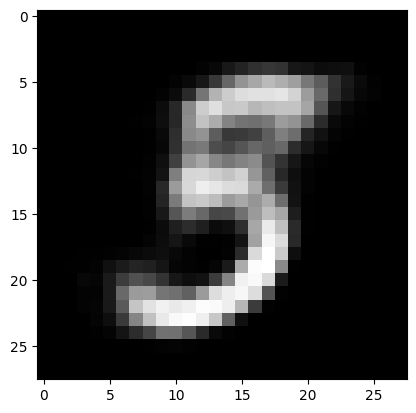

e: 0.8301601409912109


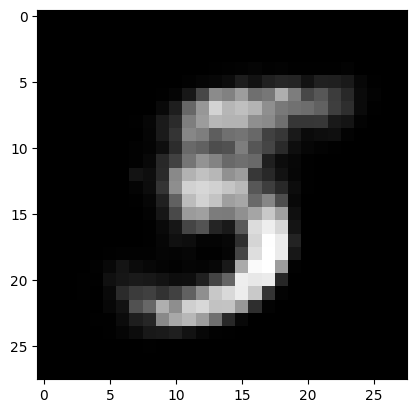

e: 1.6603202819824219


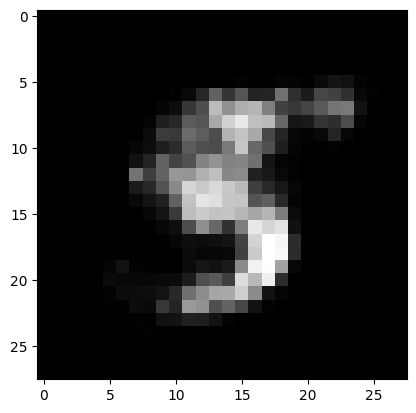

e: 2.490480422973633


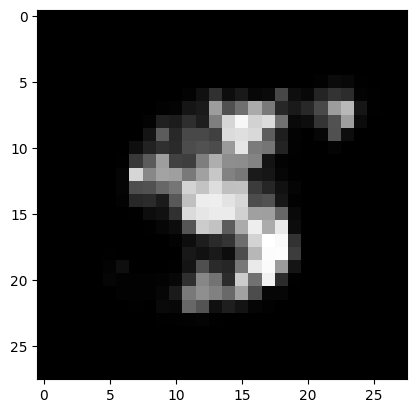

e: 3.3206405639648438


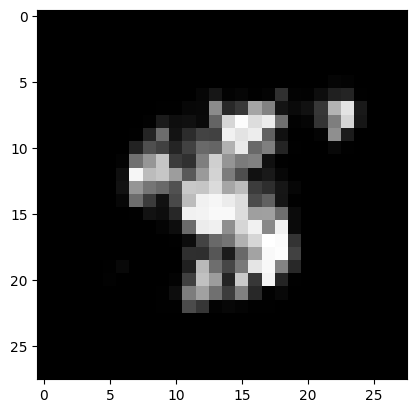

e: 4.150800704956055


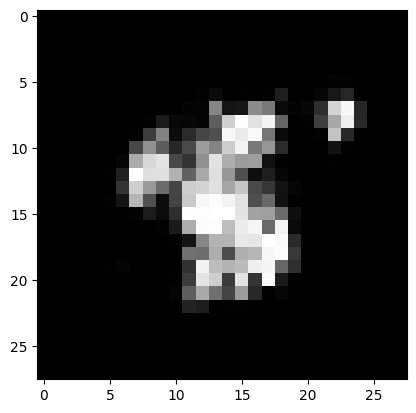

e: 4.980960845947266


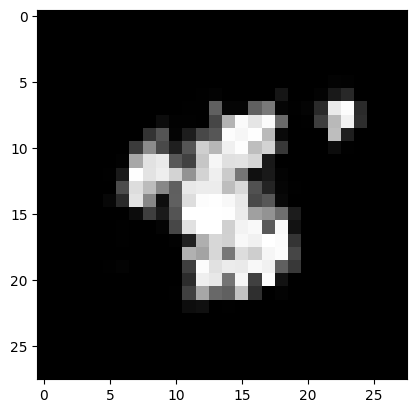

e: 5.811120986938477


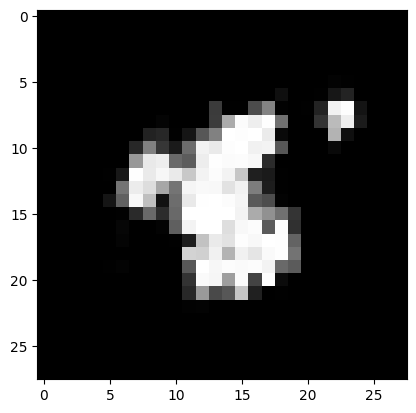

e: 6.6412811279296875


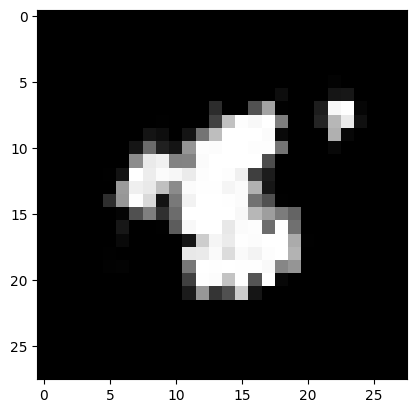

e: 7.471441268920898


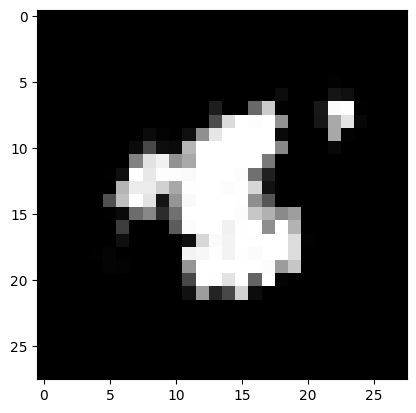

e: 8.30160140991211


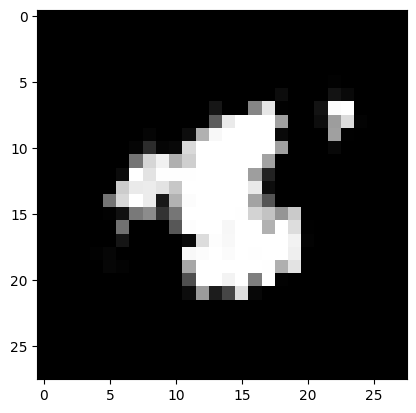

In [40]:
example = train_data[0][0]
print("Original image")
plt.imshow(example.reshape((28, 28)), cmap='gray')
plt.show()

x = np.expand_dims(example.numpy(), 0) # Dodatkowy wymiar na pozycję przypadku w 'batchu', by wymiarowość się zgadzała
x = x.reshape(-1, 784)
# Po uczeniu wykonanym w poprzednim zadaniu, mamy dostęp do już nauczonych składowych sieci
with torch.no_grad():
    latent_vector = model.encoder(torch.tensor(x).to(device)).cpu().numpy()
    output = model.decoder(torch.tensor(latent_vector).to(device)).cpu().numpy()


print("Reconstructed image")
plt.imshow(output.reshape((28, 28)), cmap='gray')
plt.show()

print(f"latent_vector: {latent_vector}")

for e in np.linspace(np.min(latent_vector), np.max(latent_vector), 11):
  print(f"e: {e}")
  modified_latent_vector = latent_vector.copy()

  # Zmień wektor zmiennych ukrytych, ustawiając wartość e w odpowiednim polu wektora
  modified_latent_vector[0, 0] = e
  # Użyj dekodera by wygenerować obrazek z nowego wektora zmiennych ukrytych
  with torch.no_grad():
    modified_output = model.decoder(torch.tensor(modified_latent_vector).to(device)).cpu().numpy()
  # Pokaż wynikowy obrazek
  plt.imshow(modified_output.reshape((28, 28)), cmap='gray')
  plt.show()

### Zadanie 8

Wykorzystaj kod z poprzednich zadań by nauczyć autoenkoder odszumiania. Parę uwag:
* Musisz zmodyfikować zbiór uczący poprzez dodanie sztucznego szumu. Można to zrobić albo poprzez zmianę wartości kilku losowych pikseli w każdym obrazku, albo dodanie macierzy z małymi losowo generowanymi liczbami do obrazka (do każdego obrazka innej!). Oczekiwaną odpowiedzą podczas uczenia będzie oryginalny obrazek bez szumu.
* Architektura enkodera i dekodera może pozostać bez zmian, ale będziesz musiał ją nauczyć na nowym zbiorze danych, tak więc by nie psuć wyników z zadania nr 6 sugeruję przeklejenie odpowiedniego kodu tutaj.
* Zademonstruj działanie odszumiania poprzez pokazanie przypadku z szumem, a następnie zrekonstruowanego obrazka bez szumu po przetworzeniu przez autoenkoder.

Epoch 1/10, Train Loss: 0.0606
Epoch 2/10, Train Loss: 0.0407
Epoch 3/10, Train Loss: 0.0364
Epoch 4/10, Train Loss: 0.0336
Epoch 5/10, Train Loss: 0.0316
Epoch 6/10, Train Loss: 0.0305
Epoch 7/10, Train Loss: 0.0298
Epoch 8/10, Train Loss: 0.0292
Epoch 9/10, Train Loss: 0.0287
Epoch 10/10, Train Loss: 0.0283


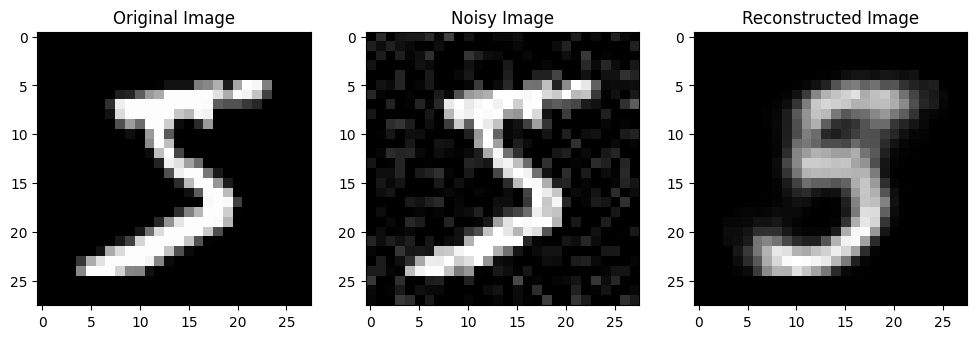

In [43]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 784),
            nn.Sigmoid(),
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                init.constant_(m.bias, 0)

    def forward(self, x):
        # Ensure input is flattened
        x = x.view(-1, 784)
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        return decoded


# Dodanie szumu poprzez nałożenie macierzy
def add_noise(images, noise_factor=0.1):
    noise = torch.randn_like(images) * noise_factor
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)


# Utworzenie modelu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Pętla ucząca z szumem
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        noisy_images = add_noise(images).to(device)
        # Forward pass
        outputs = model(noisy_images)
        loss = criterion(outputs, images.view(-1, 784))
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}")

model.eval()
example, _ = train_data[0]
noisy_example = add_noise(example.unsqueeze(0)).to(device)
with torch.no_grad():
    reconstructed = model(noisy_example).cpu().numpy()

plt.figure(figsize=(12, 4))

# Oryginalne
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(example.view(28, 28).numpy(), cmap='gray')

# Zaszumione
plt.subplot(1, 3, 2)
plt.title("Noisy Image")
plt.imshow(noisy_example.view(28, 28).cpu().numpy(), cmap='gray')

# Zrekonstruowane
plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
plt.imshow(reconstructed.reshape(28, 28), cmap='gray')

plt.show()